# **Image Enhancing: Denoising with Convolutional Autoencoder**

data celeba_128x128, subset, 60k data, source https://www.kaggle.com/jessicali9530/celeba-dataset

model convoluational autoencoder, unit= 32, maxpool2x2, 64, 4, enc=4096; ir=0.001, 0.95 decay, 20 epochs

input images: original images 128x128x3

decoded images are compare to input images

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
#import pydot
import os
import math, time, random, datetime


import tensorflow as tf
print(tf.__version__)

from sklearn.model_selection import train_test_split

import cv2

#keras = tf.keras

#from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Cropping2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard, EarlyStopping

#import tensorflow_datasets as tfds
#from tensorflow.keras.datasets import cifar10
from google.colab import files

2.1.0-rc1


In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

## load input dataset and create nosiy data


In [0]:
HEIGHT = 128
WIDTH = 128
CHAN = 3
batch_size = 100

drive = '/content/celeba_128fay/'

datagen = ImageDataGenerator(
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #horizontal_flip=True,
    #channel_shift_range=25.,
    rescale=1./255
        )

datagen_test = ImageDataGenerator(
        rescale=1./255
        )

train_gen = datagen.flow_from_directory(drive + 'train1/', 
                                          target_size=(HEIGHT,WIDTH), 
                                          batch_size=batch_size, 
                                          class_mode=None,
                                          shuffle=True)
test_gen = datagen_test.flow_from_directory(drive + 'test1', 
                                       target_size=(HEIGHT,WIDTH), 
                                       batch_size=batch_size, 
                                       class_mode=None,
                                       shuffle=False)

train_gen.n

Found 50000 images belonging to 1 classes.
Found 10000 images belonging to 1 classes.


50000

In [0]:
def noise_generator(generator, amp):
    
    for batch in generator:
        noise_batch = (batch + amp*np.random.normal(loc=0.0, scale=1.0, size=batch.shape)).clip(0.,1.) 
        yield (noise_batch, batch)


# to generator a ML model that works as a mild filter to reduce random noise wiht amp=0.05 of max amp of the image
amp = 0.03
train_in_gen = noise_generator(train_gen, amp)
test_in_gen = noise_generator(test_gen, amp)

test_n = 1000
test_steps = math.ceil(test_n/batch_size)
test_gen.reset()
test_images_noisy=np.vstack([next(test_in_gen)[0] for i in range(test_steps)])
test_gen.reset()
test_images=np.vstack([next(test_in_gen)[1] for i in range(test_steps)])


In [0]:
def plot_images(img, n0, n):
  plt.figure(figsize=(24, 2))
  for i in range(n0,n0+n):
   
    # display original + noise
    plt.subplot(1, n, i+1-n0)
    plt.imshow(img[i,:,:].reshape(HEIGHT,WIDTH,CHAN).clip(.0,1.))
    plt.axis('off')

  plt.show()

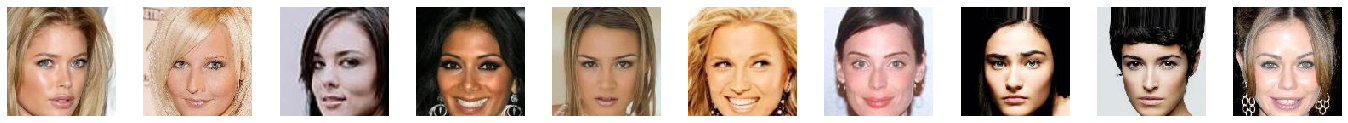

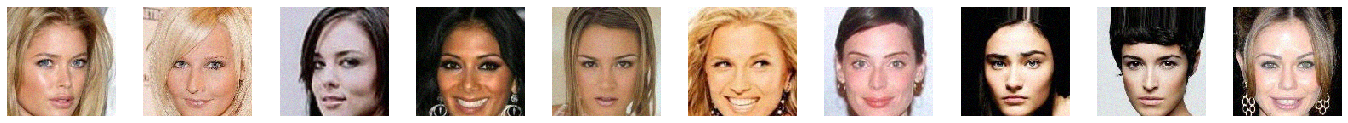

In [0]:
n0=0
n = 10

plot_images(test_images,n0,n)
plot_images(test_images_noisy,n0,n)

#ang[:10]

In [0]:
test_images.shape

(1000, 128, 128, 3)

## autoencoder


In [0]:
def ssim(true_img, pred_img):
  return tf.reduce_mean(tf.image.ssim(true_img, pred_img))

In [0]:
REP = 1024

inputs = Input(shape=(HEIGHT,WIDTH,CHAN)) 

X = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
X = MaxPooling2D((2, 2), padding='same')(X)
X = Conv2D(64, (3,3), activation='relu', padding='same')(X)
X = MaxPooling2D((2, 2), padding='same')(X)
X = Conv2D(64, (3,3), activation='relu', padding='same')(X)
X = Conv2D(4, (3,3), activation='relu', padding='same')(X)
X = Flatten()(X)
#X = Dense(REP, activation='relu')(X)

#X = Dense(32*32*4, activation='relu')(X)
X  = Reshape((32,32,4))(X)
X = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(X)
X = Conv2DTranspose(64, (3,3), activation='relu', padding='same')(X)
X = UpSampling2D((2, 2))(X)
X = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(X)
X = UpSampling2D((2, 2))(X)
DEC = Conv2DTranspose(CHAN, (3,3), activation='linear', padding='same')(X)

autoencoder = Model(inputs, DEC)

autoencoder.compile(optimizer=Adam(), loss='mse') # loss=ssim, metrics=[ssim, 'accuracy'])

autoencoder.summary()

#tf.keras.utils.plot_model(autoencoder)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 4)         2308

<h3>train model</h3>


In [0]:
lr0=0.001
annealer = LearningRateScheduler(lambda x: lr0 * 1 ** x) 
# 0.95^10=.60, ^20=.36, ^30=.21, ^40=.13

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

initial_epoch = 0
epochs = 20

steps_per_epoch = math.ceil(train_gen.n / batch_size)
validation_steps = math.ceil(test_gen.n / batch_size)

history=autoencoder.fit(train_in_gen, 
                                steps_per_epoch=steps_per_epoch,
                                epochs=epochs,
                                validation_data=test_in_gen,
                                validation_steps=validation_steps,
                                initial_epoch=initial_epoch,
                                callbacks=[annealer, es]
                                   )  #, TensorBoard(log_dir='./logs', histogram_freq=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 100 steps
Epoch 1/20
500/500 [==============================] - 188s 375ms/step - loss: 0.0077 - val_loss: 0.0026
Epoch 2/20
500/500 [==============================] - 187s 373ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 3/20
500/500 [==============================] - 186s 372ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/20
500/500 [==============================] - 187s 373ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/20
500/500 [==============================] - 184s 367ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/20
500/500 [==============================] - 184s 368ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/20
500/500 [==============================] - 185s 369ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/20
500/500 [==============================] - 183s 367ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/20
500/500 [==============================] - 183s 365ms/step - lo

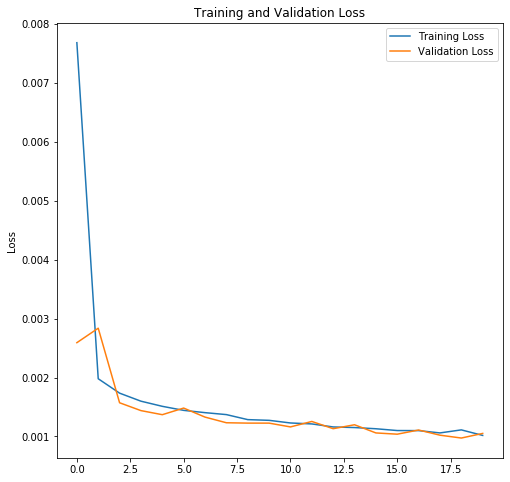

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
#plt.ylim([0,1])
plt.title('Training and Validation Loss')

plt.show()

In [0]:
gdrive_m="/content/models/"

autoencoder.save(gdrive_m + "autoencoder_v3.3.1_celeba128_denoise.h5")

In [0]:
amp=0.05

test_gen.reset()
test_images_noisy=np.vstack([next(noise_generator(test_gen, amp))[0] for i in range(test_steps)])

test_gen.reset()
test_images_output = autoencoder.predict(noise_generator(test_gen,amp),
                              steps=test_steps,
                              verbose=1)

10/10 [==============================] - 3s 297ms/step


noisy images


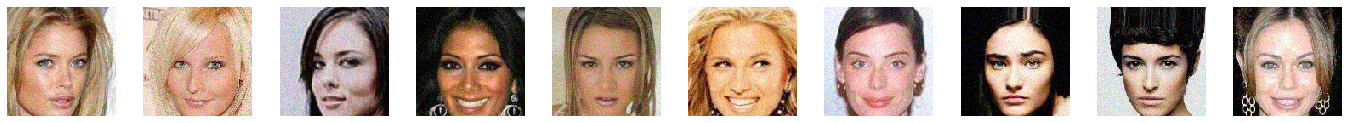


denoised images


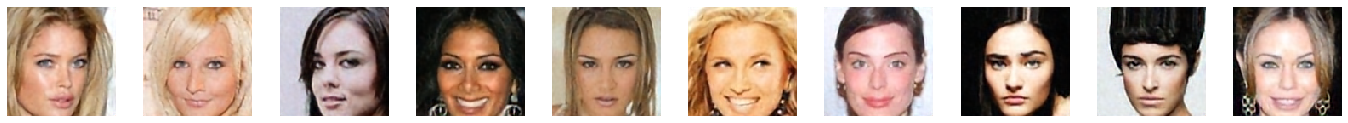


original images


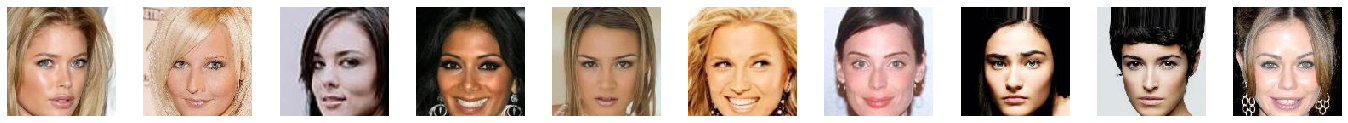

In [0]:
n0 = 0
n = 10

print("noisy images")
plot_images(test_images_noisy,n0,n)
print("\ndenoised images")
plot_images(test_images_output,n0,n)
print("\noriginal images")
plot_images(test_images,n0,n)

## **Result**

More noisy (amp=0.05) was added to the test images than the model trained for (amp=0.03 for training data). The noise is reduced effectively while some residue is visible due to the above reason. The quality of the image reconstruaction is acceptable.




# **References**


https://blog.keras.io/building-autoencoders-in-keras.html

https://medium.com/activating-robotic-minds/how-to-reduce-image-noises-by-autoencoder-65d5e6de543


